In [4]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline
matplotlib.rcParams['figure.facecolor']='#ffffff' #background white

In [5]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape:  torch.Size([1, 28, 28])
label: 5


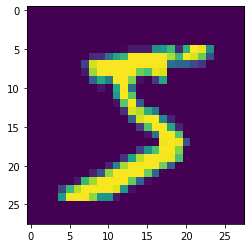

In [12]:
image , label =dataset[0]
print('image.shape: ',image.shape)
plt.imshow(image.permute(1,2,0))
print('label:',label)

label: 5


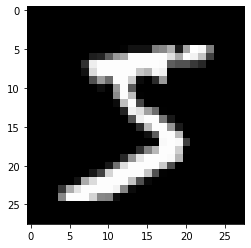

In [13]:
plt.imshow(image.permute(1,2,0),cmap='gray')
print('label:',label)

In [16]:
val_size=10000
train_size=len(dataset)-val_size

train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [18]:
batch_size=128
train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader= DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


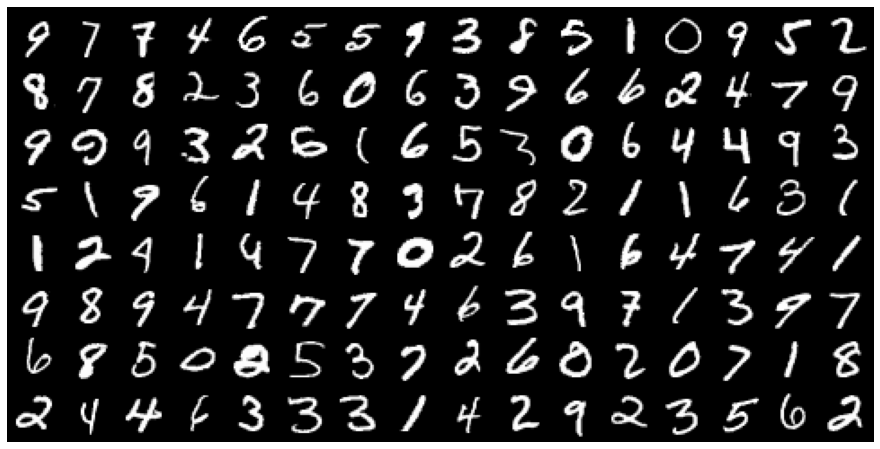

In [19]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [21]:
for images, labels in train_loader:
    print('images.shape',image.shape)
    inputs = images.reshape(-1,784)
    print('inputs.shape:',inputs.shape)
    break


images.shape torch.Size([1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [24]:
inputs[:5].shape

torch.Size([5, 784])

In [25]:
input_size=inputs.shape[-1]
hidden_size=32


In [26]:
layer1=nn.Linear(input_size,hidden_size)

In [27]:
inputs.shape

torch.Size([128, 784])

In [29]:
layer1_outputs=layer1(inputs)
print('layer1_outputs.shape',layer1_outputs.shape)

layer1_outputs.shape torch.Size([128, 32])


In [30]:
layer1_outputs_direct= inputs @ layer1.weight.t()+layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [31]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [33]:
relu_outputs=F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6064135432243347
min(relu_outputs): 0.0


In [38]:
output_size=10
layer2=nn.Linear(hidden_size,output_size)

In [40]:
layer2_outputs=layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [41]:
inputs.shape

torch.Size([128, 784])

In [42]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.2953, grad_fn=<NllLossBackward0>)

In [43]:
outputs=(F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() +layer2.bias

In [44]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [45]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [46]:
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [47]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [48]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [49]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [51]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [52]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [55]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [56]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.285062313079834
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1436,  0.1765, -0.1414, -0.1071,  0.0567, -0.0877, -0.0936, -0.1369,
         -0.1514,  0.0215],
        [-0.1518,  0.1317, -0.0343, -0.0387,  0.1200, -0.0069, -0.1492, -0.1814,
         -0.1084,  0.0035]])


In [57]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [59]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)


In [60]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3165857791900635, 'val_acc': 0.11640624701976776}]

In [63]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1295, val_acc: 0.9695
Epoch [1], val_loss: 0.1370, val_acc: 0.9695
Epoch [2], val_loss: 0.1327, val_acc: 0.9704
Epoch [3], val_loss: 0.1367, val_acc: 0.9681
Epoch [4], val_loss: 0.1356, val_acc: 0.9706
Epoch [5], val_loss: 0.1539, val_acc: 0.9637
Epoch [6], val_loss: 0.1531, val_acc: 0.9667
Epoch [7], val_loss: 0.1575, val_acc: 0.9622
Epoch [8], val_loss: 0.1419, val_acc: 0.9682
Epoch [9], val_loss: 0.1454, val_acc: 0.9701


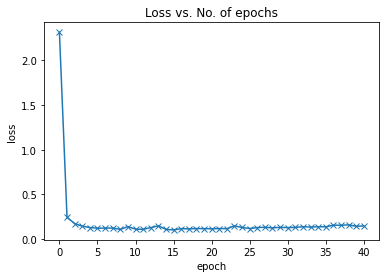

In [64]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

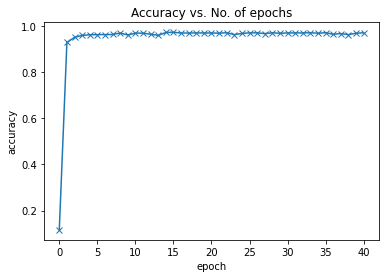

In [65]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [66]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [68]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


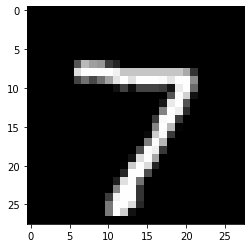

In [69]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


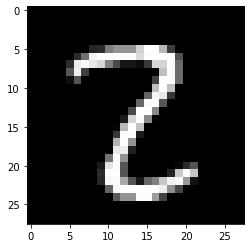

In [70]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [72]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.14619973301887512, 'val_acc': 0.968945324420929}